# Initialization

In [1]:
import tensorflow
import pandas
import numpy
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from statistics import mean

import matplotlib.pyplot as plt

from google.colab import drive

# Data Import & Preparation

In [2]:
def replace_nan(x):
    if x == " ":
        return numpy.nan
    else:
        return float(x)

def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]  

In [3]:
drive.mount('/content/drive', force_remount=True)
train_file = "/content/drive/My Drive/data/Train.csv"

Mounted at /content/drive


In [4]:
data_set = pandas.read_csv(train_file)

features = ["temp", "precip", "rel_humidity", "wind_dir", "wind_spd", "atmos_press"]   
for feature in features : 
    data_set[feature] = data_set[feature].apply(lambda x: [replace_nan(X) for X in x.replace("nan", " ").split(",")])
    data_set[feature] = data_set[feature].apply(remove_nan_values)

for x in range(121):
    data_set["temp" + str(x)] = data_set.temp.str[x]
    data_set["precip" + str(x)] = data_set.precip.str[x]
    data_set["rel_humidity" + str(x)] = data_set.rel_humidity.str[x]
    data_set["wind_dir" + str(x)] = data_set.wind_dir.str[x]
    data_set["wind_spd" + str(x)] = data_set.wind_spd.str[x]
    data_set["atmos_press" + str(x)] = data_set.atmos_press.str[x]

data_set.drop(features, 1, inplace = True)

display(data_set.head())

,ID,location,target,temp0,precip0,rel_humidity0,wind_dir0,wind_spd0,atmos_press0,temp1,precip1,rel_humidity1,wind_dir1,wind_spd1,atmos_press1,temp2,precip2,rel_humidity2,wind_dir2,wind_spd2,atmos_press2,temp3,precip3,rel_humidity3,wind_dir3,wind_spd3,atmos_press3,temp4,precip4,rel_humidity4,wind_dir4,wind_spd4,atmos_press4,temp5,precip5,rel_humidity5,wind_dir5,wind_spd5,atmos_press5,temp6,...,rel_humidity114,wind_dir114,wind_spd114,atmos_press114,temp115,precip115,rel_humidity115,wind_dir115,wind_spd115,atmos_press115,temp116,precip116,rel_humidity116,wind_dir116,wind_spd116,atmos_press116,temp117,precip117,rel_humidity117,wind_dir117,wind_spd117,atmos_press117,temp118,precip118,rel_humidity118,wind_dir118,wind_spd118,atmos_press118,temp119,precip119,rel_humidity119,wind_dir119,wind_spd119,atmos_press119,temp120,precip120,rel_humidity120,wind_dir120,wind_spd120,atmos_press120
0,ID_train_0,C,45.126304,26.909091,0.000,0.510818,272.902752,0.800909,87.777273,27.208333,0.0,0.535417,104.565241,1.073333,87.652500,26.183333,0.0,0.614500,167.177225,1.517500,87.614167,24.700000,0.000,0.633000,165.332855,1.462500,87.637500,23.658333,0.000,0.683750,111.208901,0.516667,87.717500,22.741667,0.0,0.761500,86.041616,0.295000,87.762500,22.158333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_train_1,D,79.131702,22.533333,0.102,0.744583,281.664310,2.377500,90.320000,21.716667,0.0,0.808083,89.156293,1.126667,90.377500,20.833333,0.0,0.911167,81.968539,0.700833,90.440833,20.983333,0.000,0.916333,291.018632,0.341667,90.472500,20.875000,0.000,0.929750,279.391524,0.440833,90.454167,20.141667,0.0,0.954000,158.026892,0.380000,90.394167,19.375000,...,0.600083,97.603374,1.395833,90.481667,30.233333,0.0,0.556917,69.085542,1.589167,90.354167,30.583333,0.0,0.520833,171.660338,1.695833,90.272500,28.466667,0.0,0.603083,183.291765,2.548333,90.266667,26.991667,0.0,0.651000,213.937567,1.369167,90.325833,26.025000,0.0,0.649250,73.528733,1.475833,90.439167,21.450000,0.561,0.797333,296.967254,1.019167,90.529167
2,ID_train_10,A,32.661304,28.975000,0.000,0.573333,328.682914,1.032500,88.551667,27.950000,0.0,0.597167,307.825146,1.193333,88.464167,29.600000,0.0,0.566833,319.017751,1.275833,88.319167,26.425000,0.102,0.627667,264.865746,1.493333,88.240000,22.091667,0.136,0.755417,253.217152,1.870833,88.230000,21.775000,0.0,0.777417,251.433371,1.844167,88.268333,22.333333,...,0.881333,NaN,NaN,88.448333,23.541667,0.0,0.734750,NaN,NaN,88.500000,26.408333,0.0,0.603000,NaN,NaN,88.495000,28.075000,0.0,0.496667,NaN,NaN,88.515833,29.241667,0.0,0.459583,NaN,NaN,88.475833,30.091667,0.0,0.437917,NaN,NaN,88.415833,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_train_100,A,53.850238,22.966667,0.000,0.843083,300.085057,1.446667,88.615000,24.266667,0.0,0.790250,293.676960,1.192500,88.530833,25.275000,0.0,0.737500,294.517465,1.324167,88.400000,25.625000,0.000,0.728000,301.921417,1.544167,88.271667,25.866667,0.000,0.704917,334.568073,1.915833,88.207500,25.091667,0.0,0.741167,319.576411,1.840000,88.178333,24.025000,...,0.970167,NaN,NaN,88.382500,17.625000,0.0,0.983833,NaN,NaN,88.406667,18.308333,0.0,0.990833,NaN,NaN,88.449167,20.325000,0.0,0.930417,NaN,NaN,88.507500,21.900000,0.0,0.856500,NaN,NaN,88.500000,23.533333,0.0,0.766417,NaN,NaN,88.490833,24.641667,0.000,0.719667,NaN,NaN,88.465833
4,ID_train_1000,A,177.418750,21.875000,0.000,0.856417,21.839974,0.197500,88.556667,21.575000,0.0,0.874917,17.054053,0.244167,88.640833,21.525000,0.0,0.879833,89.264060,0.411667,88.658333,21.433333,0.000,0.860167,123.585424,0.560000,88.647500,20.508333,0.000,0.898000,328.708314,0.577500,88.632500,19.916667,0.0,0.908500,117.606956,0.429167,88.586667,18.991667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
training_data = data_set.drop(["ID", 'location', 'target'], axis = 1)
training_data = numpy.nan_to_num(training_data, copy = True, nan = 0)
training_data = StandardScaler().fit(training_data).transform(training_data)
training_data = numpy.reshape(training_data, (-1, 726, 1))

training_target = data_set.target

print(training_data)
print(training_target)

[[[ 1.14015773]
  [-0.11814189]
  [-1.87490884]
  ...
  [-0.83192083]
  [-0.76945147]
  [-2.13617479]]

 [[-0.07653575]
  [-0.04493134]
  [-0.32621089]
  ...
  [ 1.53638789]
  [ 0.6631622 ]
  [ 0.50793318]]

 [[ 1.7145904 ]
  [-0.11814189]
  [-1.46074494]
  ...
  [-0.83192083]
  [-0.76945147]
  [-2.13617479]]

 ...

 [[ 0.91287029]
  [-0.11814189]
  [-0.07998111]
  ...
  [-0.27021171]
  [ 2.65335895]
  [ 0.50907713]]

 [[ 1.7841037 ]
  [-0.11814189]
  [-1.09636904]
  ...
  [ 0.37770597]
  [ 1.03800797]
  [ 0.50201871]]

 [[-0.37776007]
  [-0.10594013]
  [ 0.79176062]
  ...
  [ 1.79367743]
  [ 0.41365549]
  [ 0.42982812]]]
0         45.126304
1         79.131702
2         32.661304
3         53.850238
4        177.418750
            ...    
15534     44.850286
15535     24.330455
15536     38.972128
15537     41.720952
15538    127.983333
Name: target, Length: 15539, dtype: float64


In [6]:
folds=8

def gen():
    kfold = KFold(n_splits = folds, shuffle = True)
    for train, test in kfold.split(training_data, training_target):
        X_train, X_test = training_data[train], training_data[test]
        y_train, y_test = training_target[train], training_target[test] 
        yield X_train, y_train, X_test, y_test

datasets = tensorflow.data.Dataset.from_generator(gen, (tensorflow.float64, tensorflow.float64, tensorflow.float64, tensorflow.float64))

# Create CNN Model

In [7]:
cnn = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Conv1D(filters = 16, kernel_size = 4, activation = 'relu', input_shape = (726,1)),
    tensorflow.keras.layers.Conv1D(filters = 16, kernel_size = 4, activation = 'relu'),
    tensorflow.keras.layers.MaxPool1D(pool_size = 4),
    tensorflow.keras.layers.Conv1D(filters = 8, kernel_size = 2, activation = 'relu'),
    tensorflow.keras.layers.Conv1D(filters = 8, kernel_size = 2, activation = 'relu'),
    tensorflow.keras.layers.MaxPool1D(pool_size = 2),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(16, activation = 'relu'),
    tensorflow.keras.layers.Dense(1)
])

# Training

In [8]:
tensorflow.random.set_seed(12345)
epochs = 16

In [9]:
cnn.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.003), loss='mse', metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])

results = []

for i in range(3):
    fold = 0
    for train_data, validate_data, train_target, validate_target in datasets:
        fold = fold + 1
        print("\n--- Training fold " + str(fold) + " of " + str(folds) + " ---")
        result = cnn.fit(train_data, validate_data, epochs = epochs, shuffle = False, validation_data = (train_target, validate_target))
        results.append(result.history)
    epochs = int(epochs/2)


--- Training fold 1 of 8 ---
Epoch 1/16
425/425 [==============================] - 11s 27ms/step - loss: 1863.4578 - root_mean_squared_error: 43.1678 - val_loss: 1672.4104 - val_root_mean_squared_error: 40.8951
Epoch 2/16
425/425 [==============================] - 11s 26ms/step - loss: 1499.9772 - root_mean_squared_error: 38.7295 - val_loss: 1440.8929 - val_root_mean_squared_error: 37.9591
Epoch 3/16
425/425 [==============================] - 11s 27ms/step - loss: 1358.0151 - root_mean_squared_error: 36.8513 - val_loss: 1335.4216 - val_root_mean_squared_error: 36.5434
Epoch 4/16
425/425 [==============================] - 12s 27ms/step - loss: 1263.2922 - root_mean_squared_error: 35.5428 - val_loss: 1280.5077 - val_root_mean_squared_error: 35.7842
Epoch 5/16
425/425 [==============================] - 11s 26ms/step - loss: 1197.0382 - root_mean_squared_error: 34.5982 - val_loss: 1241.7643 - val_root_mean_squared_error: 35.2387
Epoch 6/16
425/425 [==============================] - 11s 26

# Results

In [10]:
TrainingLoss = [d['loss'] for d in results]
TrainingRMSE = [d['root_mean_squared_error'] for d in results]

In [11]:
ValidationLoss = [d['val_loss'] for d in results]
ValidationRMSE = [d['val_root_mean_squared_error'] for d in results]

In [12]:
print("Training Loss:" + str(TrainingLoss))
print("Validation Loss:" + str(ValidationLoss))
print("Training RMSE:" + str(TrainingRMSE))
print("Validation RMSE:" + str(ValidationRMSE))

Training Loss:[[1863.457763671875, 1499.9771728515625, 1358.01513671875, 1263.292236328125, 1197.0382080078125, 1144.270263671875, 1102.70703125, 1063.25634765625, 1025.129638671875, 996.0248413085938, 962.364013671875, 930.9967651367188, 902.4891967773438, 872.9271240234375, 843.93701171875, 817.5935668945312], [844.5792236328125, 812.806396484375, 777.7332763671875, 749.8297729492188, 721.1510620117188, 702.081787109375, 674.667236328125, 659.0210571289062, 644.737060546875, 631.9209594726562, 626.8677368164062, 609.9658203125, 612.573486328125, 601.1643676757812, 585.5895385742188, 589.2800903320312], [704.2825927734375, 655.0872802734375, 622.1600952148438, 605.9496459960938, 592.4052124023438, 579.0379638671875, 573.746337890625, 564.2371826171875, 564.7811279296875, 561.2477416992188, 549.785400390625, 538.5777587890625, 546.242919921875, 547.487060546875, 544.586669921875, 539.83740234375], [636.0509033203125, 575.639892578125, 552.7676391601562, 531.0778198242188, 517.498474121

In [13]:
def flattenMeans(lst):
    retList = []
    for item in lst:
        retList.append(mean(item))
    return retList

TrainingLoss_means = flattenMeans(TrainingLoss)
TrainingRMSE_means = flattenMeans(TrainingRMSE)
ValidationLoss_means = flattenMeans(ValidationLoss)
ValidationRMSE_means = flattenMeans(ValidationRMSE)

print("Training Loss Means:" + str(TrainingLoss_means))
print("Validation Loss Means:" + str(ValidationLoss_means))
print("Training RMSE Means:" + str(TrainingRMSE_means))
print("Validation RMSE Means:" + str(ValidationRMSE_means))

Training Loss Means:[1115.217269897461, 677.7480545043945, 580.5907745361328, 515.0635013580322, 478.3173122406006, 453.0405082702637, 429.2835865020752, 404.266263961792, 411.3225898742676, 397.71368408203125, 389.0207710266113, 381.55990982055664, 373.443302154541, 372.9111976623535, 371.32303619384766, 368.79394149780273, 362.6374053955078, 362.7262420654297, 361.48941802978516, 359.89959716796875, 355.6755142211914, 354.92382049560547, 349.9451446533203, 344.1327362060547]
Validation Loss Means:[1246.2709884643555, 1056.7058486938477, 897.6855278015137, 815.4358444213867, 717.232063293457, 654.4095420837402, 620.7008361816406, 653.3095092773438, 531.9385757446289, 520.6086616516113, 557.9336051940918, 522.2438812255859, 524.5954475402832, 550.0895080566406, 562.9051055908203, 541.2070121765137, 538.1146545410156, 520.4978637695312, 471.75337982177734, 461.43277740478516, 567.3260192871094, 490.73336029052734, 516.7933349609375, 514.9857788085938]
Training RMSE Means:[33.17962992191

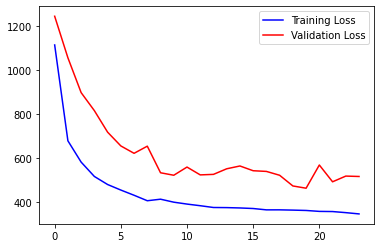

In [14]:
plt.plot(TrainingLoss_means, 'b')
plt.plot(ValidationLoss_means, 'r')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

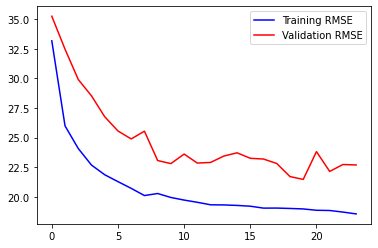

In [15]:
plt.plot(TrainingRMSE_means, 'b')
plt.plot(ValidationRMSE_means, 'r')
plt.legend(['Training RMSE', 'Validation RMSE'], loc='upper right')
plt.show()

In [16]:
print("For the last run (last 8 folds):")

print("Minimum Training Loss:\t" + str(min(TrainingLoss_means[-8:])))
print("Minimum Validation Loss:\t" + str(min(ValidationLoss_means[-8:])))
print("Mean Training Loss:\t" + str(mean(TrainingLoss_means[-8:])))
print("Mean Validation Loss:\t" + str(mean(ValidationLoss_means[-8:])))

print("Minimum Training RMSE:\t" + str(min(TrainingRMSE_means[-8:])))
print("Minimum Validation RMSE:\t" + str(min(ValidationRMSE_means[-8:])))
print("Mean Training RMSE:\t" + str(mean(TrainingRMSE_means[-8:])))
print("Mean Validation RMSE:\t" + str(mean(ValidationRMSE_means[-8:])))

For the last run (last 8 folds):
Minimum Training Loss:	344.1327362060547
Minimum Validation Loss:	461.43277740478516
Mean Training Loss:	356.4287347793579
Mean Validation Loss:	510.20464611053467
Minimum Training RMSE:	18.55017900466919
Minimum Validation RMSE:	21.465875148773193
Mean Training RMSE:	18.877330541610718
Mean Validation RMSE:	22.567537307739258
